In [1]:
%load_ext autoreload
%autoreload 2

In [139]:
import functools
import collections

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
import re
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import ablation, prompt_data, utils, datasets, vocab, decomp

In [8]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    move_to_device=True,
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
)
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    move_to_device=True,
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
)

with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

    _, tmp_cache = tl_model.run_with_cache("hi")
    LABELS = np.array(
        decomp.get_all_resid_components(
            tl_model=tl_model, cache=tmp_cache, pos=-1, batch_idx=0
        ).labels
    )
    print(LABELS[:5])


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions
['EMBED' 'L0H0ATN' 'L0H1ATN' 'L0H2ATN' 'L0H3ATN']


In [4]:
import pickle

filename = '/nas/pii-data/kaivu/prompt-injection-interp/data/counterfact_processed.pkl.tmp'

with open(filename, 'rb') as file:
    df = pickle.load(file)

print(df)

      case_id  pararel_idx relation_id                   subject  \
0        6515         6929         P17                Guillaumes   
1        3342         8551         P27           Howe Yoon Chong   
2       16732        16420        P136                Les McCann   
3       19542         7291         P17         Biberach district   
4       14230        16536        P136             Eumir Deodato   
...       ...          ...         ...                       ...   
3071     8795        17565        P127     BBC Domesday Reloaded   
3072    21177         2975        P103            Paul Pellisson   
3073      740         5515        P178  Windows Embedded Compact   
3074     9962         1440        P108                Paul Allen   
3075     8493        18783        P407                  Le Monde   

     target_new_str target_true_str  \
0            Norway          France   
1           Belgium       Singapore   
2           musical            jazz   
3             Libya        

In [5]:
def get_forbidden_attention(
        cache: ActivationCache,
        forbidden_indices: (int, int),

):
    # res_matrx is (layer, head,  comp_type, num_prompts)
    num_prompts = cache["blocks.0.attn.hook_pattern"].shape[0] // 3
    res_matrix = np.zeros((32, 32, 3, num_prompts))

    for layer_num in range(32):
        for head_num in range(32):
            attn_patterns = cache[f"blocks.{layer_num}.attn.hook_pattern"]
            # reshape attn_patterns from (comp_type x num_prompts, num_heads, seq_len, seq_len) to (comp_type, num_prompts, num_heads, seq_len, seq_len) with einops
            attn_patterns = einops.rearrange(attn_patterns, "(c n) h s1 s2 -> c n h s1 s2", c=3)
            for c in range(3):
                forb_attn_vals = attn_patterns[c, :, head_num, -1, forbidden_indices[0]:forbidden_indices[1]].cpu().numpy()
                #sum over last dimension of forbidden_attn_vals
                val = np.sum(forb_attn_vals, axis=1)
                res_matrix[layer_num, head_num, c, :] = val
    # rearrange to (num_prompts, comp_type, layer, head)
    res_matrix = einops.rearrange(res_matrix, "l h c n -> n c l h")
    return res_matrix

In [21]:
log_bf_nc_c = np.concatenate(
    [
        np.stack(df.lo_correct_nc0_c) - df.lo_correct_nc0.to_numpy()[:, None],
        np.stack(df.lo_correct_nc1_c) - df.lo_correct_nc1.to_numpy()[:, None],
    ]
)
log_bf_c_nc = np.concatenate(
    [
        np.stack(df.lo_correct_c_nc0) - df.lo_correct_c.to_numpy()[:, None],
        np.stack(df.lo_correct_c_nc1) - df.lo_correct_c.to_numpy()[:, None],
    ]
)
print(log_bf_c_nc.shape, log_bf_nc_c.shape)

COMPONENT_ORDER = np.argsort(log_bf_nc_c.mean(axis=0))
LABELS_ORDERED = LABELS[COMPONENT_ORDER]


important_head_list = []
for label in LABELS_ORDERED:
    #append label that contains 'H' 
    if 'H' in label:
        important_head_list.append(label)
    # break if you have 9 labels
    if len(important_head_list) == 9:
        break

(6152, 1057) (6152, 1057)


In [137]:
COMPONENT_ORDER

array([ 604,  921, 1056, ...,  744,  957,  679])

In [22]:
LABELS_ORDERED[0]

'L18H9ATN'

In [136]:
important_head_list[0][3:5]

'H9'

In [138]:
important_head_list

['L18H9ATN',
 'L27H29ATN',
 'L26H9ATN',
 'L25H12ATN',
 'L19H23ATN',
 'L22H20ATN',
 'L23H19ATN',
 'L28H7ATN',
 'L26H14ATN']

# Query substitution experiments

In [25]:
# view all column names in df
df.columns

Index(['case_id', 'pararel_idx', 'relation_id', 'subject', 'target_new_str',
       'target_true_str', 'fact_prefix', 'irrelevant_word', 'prompt_c',
       'prompt_nc0', 'prompt_nc1', 'p_correct_c', 'p_correct_nc0',
       'p_correct_nc1', 'lo_correct_c', 'lo_correct_nc0', 'lo_correct_nc1',
       'log_bf0', 'log_bf1', 'lo_correct_c_nc0', 'lo_correct_c_nc1',
       'lo_correct_nc0_c', 'lo_correct_nc1_c', 'lo_correct_c_nc0_dcum',
       'lo_correct_c_nc1_dcum', 'lo_correct_nc0_c_dcum',
       'lo_correct_nc1_c_dcum', 'lo_correct_c_nc0_cum', 'lo_correct_c_nc1_cum',
       'lo_correct_nc0_c_cum', 'lo_correct_nc1_c_cum'],
      dtype='object')

In [26]:
LAYER = 18
HEAD = 9
HEAD_STR = f"L{LAYER}H{HEAD}"
ATTN_SCALE = tl_model.blocks[LAYER].attn.attn_scale

In [144]:
def extract_layer_head(s):
    # Regular expression pattern to match 'L', one or more digits, 'H', and one or more digits
    pattern = re.compile(r'L(\d+)H(\d+)ATN')
    
    match = pattern.match(s)
    if match:
        # Convert matched groups to integers and return as a tuple
        layer, head = map(int, match.groups())
        return (layer, head)
    else:
        # If the input string doesn't match the pattern, raise a ValueError
        raise ValueError('Invalid input format')

In [146]:
#find forbidden indices
def get_forbidden_token_range(prompt: str, forbidden_word: str) -> slice:
    tokens = tl_model.to_tokens(prompt)[0]
    start = 51
    for end in range(36, len(tokens) + 1):
        if tl_model.to_string(tokens[start:end]) == forbidden_word:
            return slice(start, end)
    raise ValueError("forbidden word not found")

In [123]:
x = get_forbidden_token_range(prompt_c, df.target_true_str[0])

In [161]:
#res is (num_prompts, important_heads, 3, 3)
num_prompts = len(df)
important_heads = len(important_head_list)
res = np.zeros((num_prompts, important_heads, 3, 3))

for idx in tqdm(range(num_prompts)):
    prompt_c, forbidden_c = df.prompt_c[idx], df.target_true_str[idx]
    prompt_nc0, forbidden_nc0 = df.prompt_nc0[idx], df.target_new_str[idx]
    prompt_nc1, forbidden_nc1 = df.prompt_nc1[idx], df.irrelevant_word[idx]

    # run the tl model with the prompt
    with torch.no_grad():
        _, cache_c = tl_model.run_with_cache(prompt_c)
        _, cache_nc0 = tl_model.run_with_cache(prompt_nc0)
        _, cache_nc1 = tl_model.run_with_cache(prompt_nc1)

    prompt_list = [prompt_c, prompt_nc0, prompt_nc1]
    forbidden_list = [forbidden_c, forbidden_nc0, forbidden_nc1]
    cache_list = [cache_c, cache_nc0, cache_nc1]

    for head_id, head in enumerate(important_head_list):
        # get numbers after L, and numbers after H for layer and head
        LAYER, HEAD = extract_layer_head(head)
        # run all 3 prompts on all 3 things
        for i, (prompt, query_cache, forbidden)  in enumerate(zip(prompt_list, cache_list, forbidden_list)):
            for j,  key_cache in enumerate(cache_list):
                rot_ks1 = key_cache["rot_k", LAYER][0, :, HEAD, :]
                rot_q2 = query_cache["rot_q", LAYER][0, -1, HEAD, :]
                scores = (rot_ks1 @ rot_q2) / ATTN_SCALE
                attn = scores.softmax(dim=-1)
                forbidden_attn_slice = get_forbidden_token_range(prompt, forbidden)
                forbidden_attn = torch.sum(attn[forbidden_attn_slice]).item()
                res[idx, head_id, i, j] = forbidden_attn

  0%|          | 0/3076 [00:00<?, ?it/s]

In [162]:
checkpoint = res

In [163]:
res.shape

(3076, 9, 3, 3)

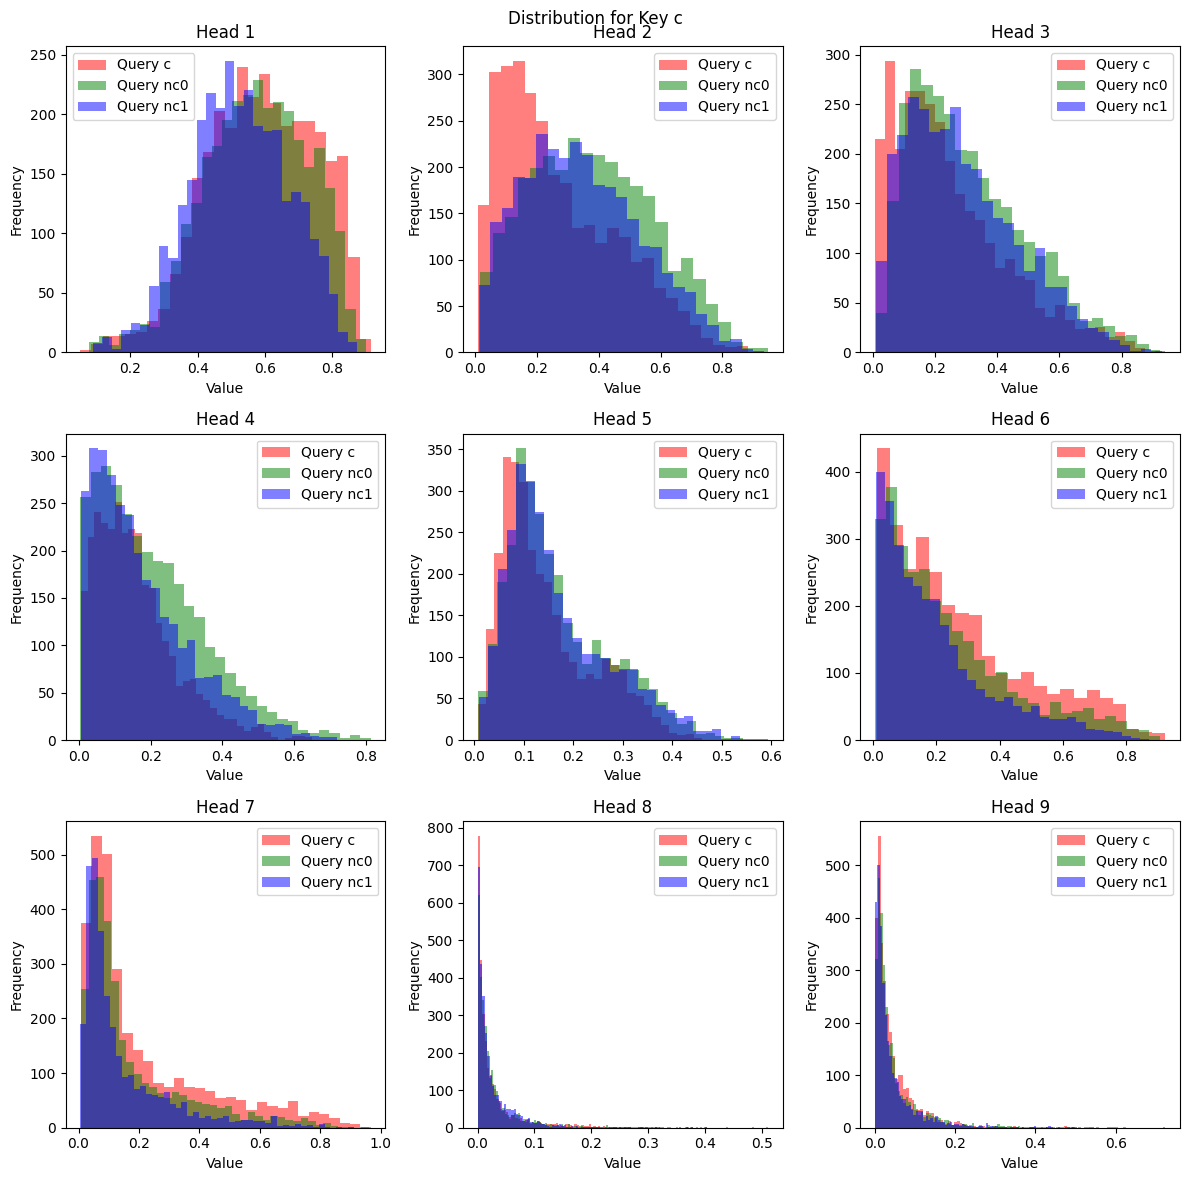

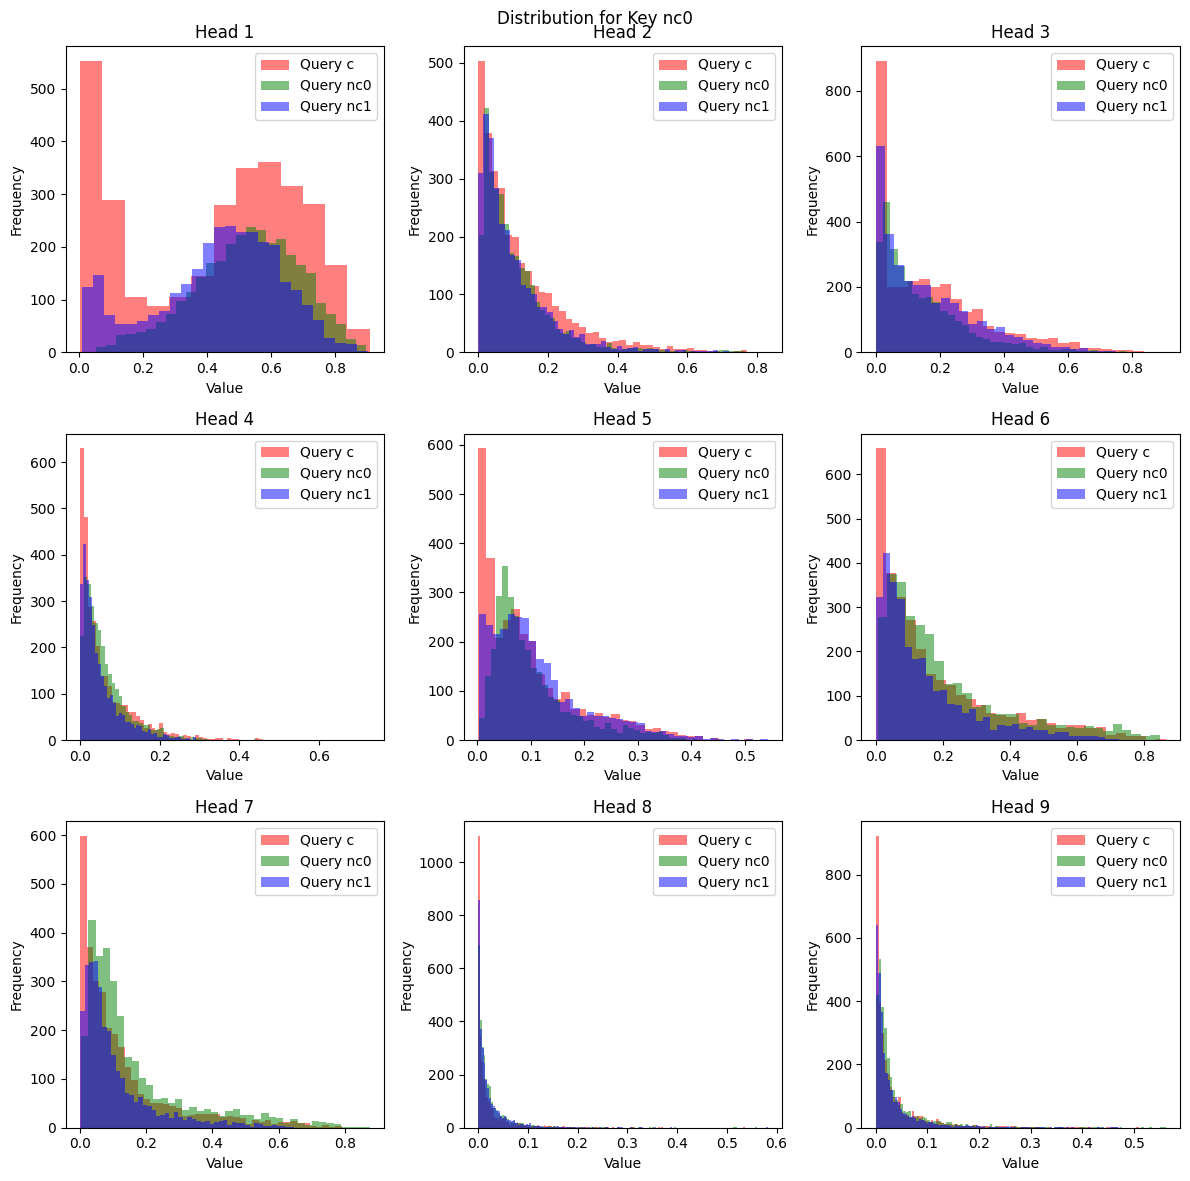

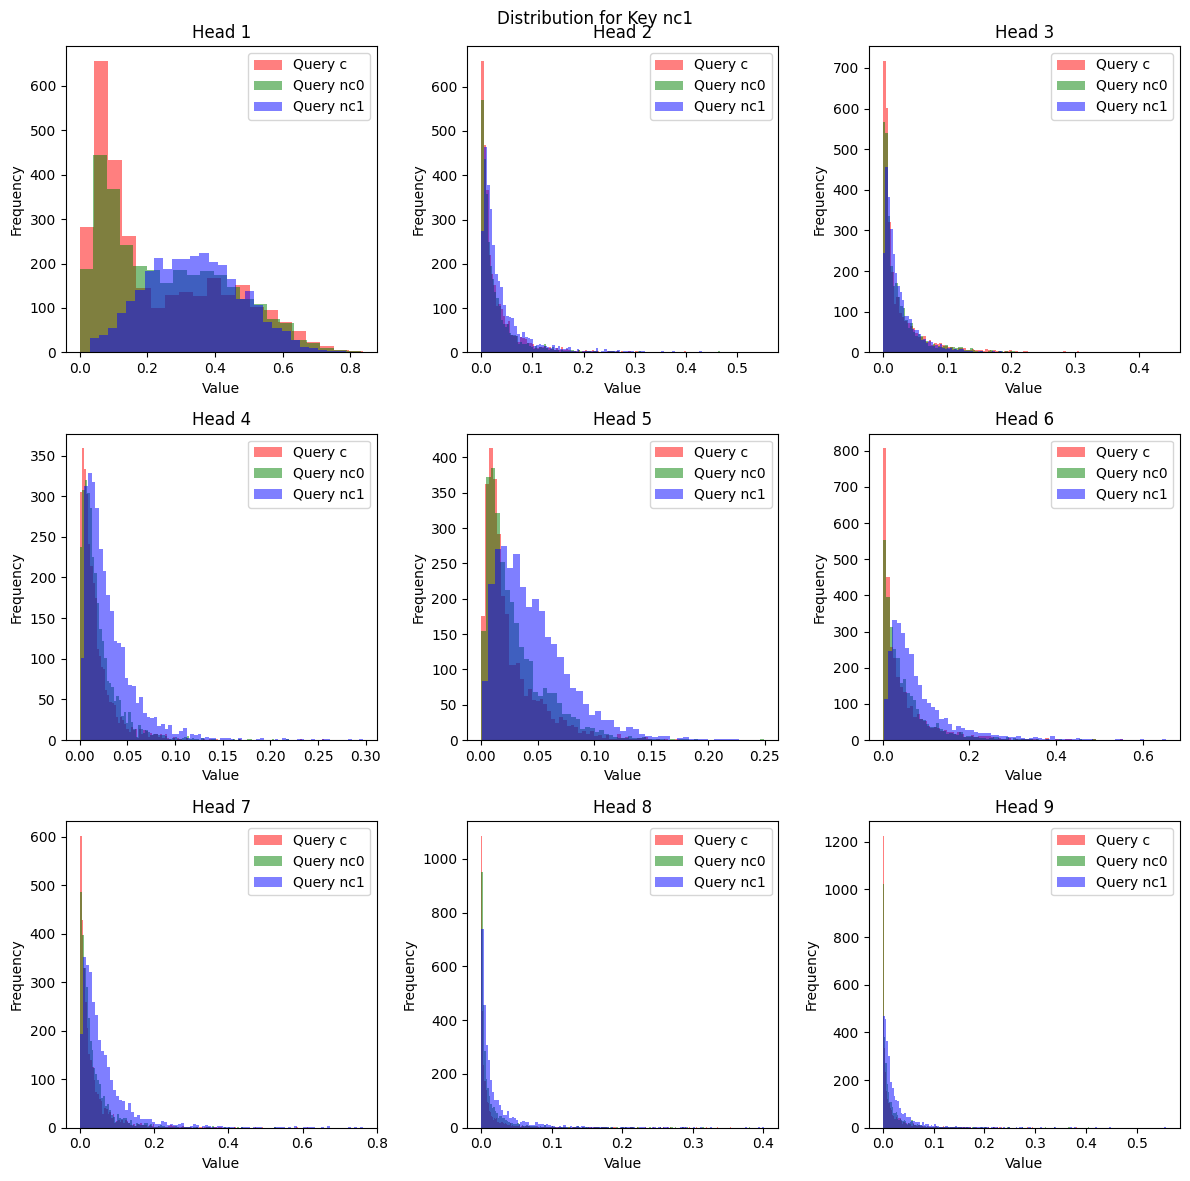

In [166]:
# Determine the dimensions from the shape of 'res'
prompts, heads, queries, keys = res.shape

# Labels for queries and keys
query_labels = ['c', 'nc0', 'nc1']
key_labels = ['c', 'nc0', 'nc1']


# Determine the dimensions from the shape of 'res'
prompts, heads, queries, keys = res.shape

# Labels for queries and keys
query_labels = ['c', 'nc0', 'nc1']
key_labels = ['c', 'nc0', 'nc1']

# Colors for different queries
colors = ['red', 'green', 'blue']

# Iterate through each key first, using enumerate to get the index and label
for key_index, key_label in enumerate(key_labels):
    # Create a new figure for each key
    plt.figure(figsize=(12, 12))
    
    # Iterate through each head
    for head in range(heads):
        # Determine the subplot position in a 3x3 grid
        position = head + 1  # positions are 1-indexed
        
        # Create the subplot
        plt.subplot(3, 3, position)
        
        # Iterate through each query, using enumerate to get the index
        for query_index, query_label in enumerate(query_labels):
            # Select the 3076 points for the current combination of head, query, and key
            data = res[:, head, query_index, key_index]
            
            # Plot the distribution as a histogram, using a different color for each query
            plt.hist(data, bins='auto', alpha=0.5, label=f'Query {query_label}', color=colors[query_index])
        
        # Label the axes and the plot
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'Head {head + 1}')
    
    # Set a main title for the whole figure
    plt.suptitle(f'Distribution for Key {key_label}')
    
    # Display the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust the top spacing to accommodate the suptitle
    plt.show()

In [ ]:
# for each head, index in (3, 3), plot the 3076 values
for head in res.shape

In [ ]:
#res is (num_prompts, important_heads, 3, 3)
num_prompts = len(df)
important_heads = len(important_head_list)
res_2 = np.zeros((num_prompts, important_heads, 3, 3))

for idx in tqdm(range(num_prompts)):
    prompt_c, forbidden_c = df.prompt_c[idx], df.target_true_str[idx]
    prompt_nc0, forbidden_nc0 = df.prompt_nc0[idx], df.target_new_str[idx]
    prompt_nc1, forbidden_nc1 = df.prompt_nc1[idx], df.irrelevant_word[idx]

    # run the tl model with the prompt
    with torch.no_grad():
        _, cache_c = tl_model.run_with_cache(prompt_c)
        _, cache_nc0 = tl_model.run_with_cache(prompt_nc0)
        _, cache_nc1 = tl_model.run_with_cache(prompt_nc1)

    prompt_list = [prompt_c, prompt_nc0, prompt_nc1]
    forbidden_list = [forbidden_c, forbidden_nc0, forbidden_nc1]
    cache_list = [cache_c, cache_nc0, cache_nc1]

    for head_id, head in enumerate(important_head_list):
        # get numbers after L, and numbers after H for layer and head
        LAYER, HEAD = extract_layer_head(head)
        # run all 3 prompts on all 3 things
        for i, (prompt, query_cache, forbidden)  in enumerate(zip(prompt_list, cache_list, forbidden_list)):
            for j,  key_cache in enumerate(cache_list):
                rot_ks1 = key_cache["rot_k", LAYER][0, :, HEAD, :]
                rot_q2 = query_cache["rot_q", LAYER][0, -1, HEAD, :]
                scores = (rot_ks1 @ rot_q2) / ATTN_SCALE
                attn = scores.softmax(dim=-1)
                forbidden_attn_slice = get_forbidden_token_range(prompt, forbidden)
                forbidden_attn = torch.sum(attn[forbidden_attn_slice]).item()
                res[idx, head_id, i, j] = forbidden_attn

In [100]:
pattern = cache_c["pattern", LAYER][0, HEAD, -1, :]
print(f"{HEAD_STR} Attention Pattern:")
display(
    cv_tokens.colored_tokens(["<< bos >>"] + prompt_c_list, pattern)
)
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + prompt_c_list[1:], np.arange(len(prompt_c_list))
    )
)

L18H9 Attention Pattern:


In [168]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

In [177]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import linregress

In [180]:
res = checkpoint

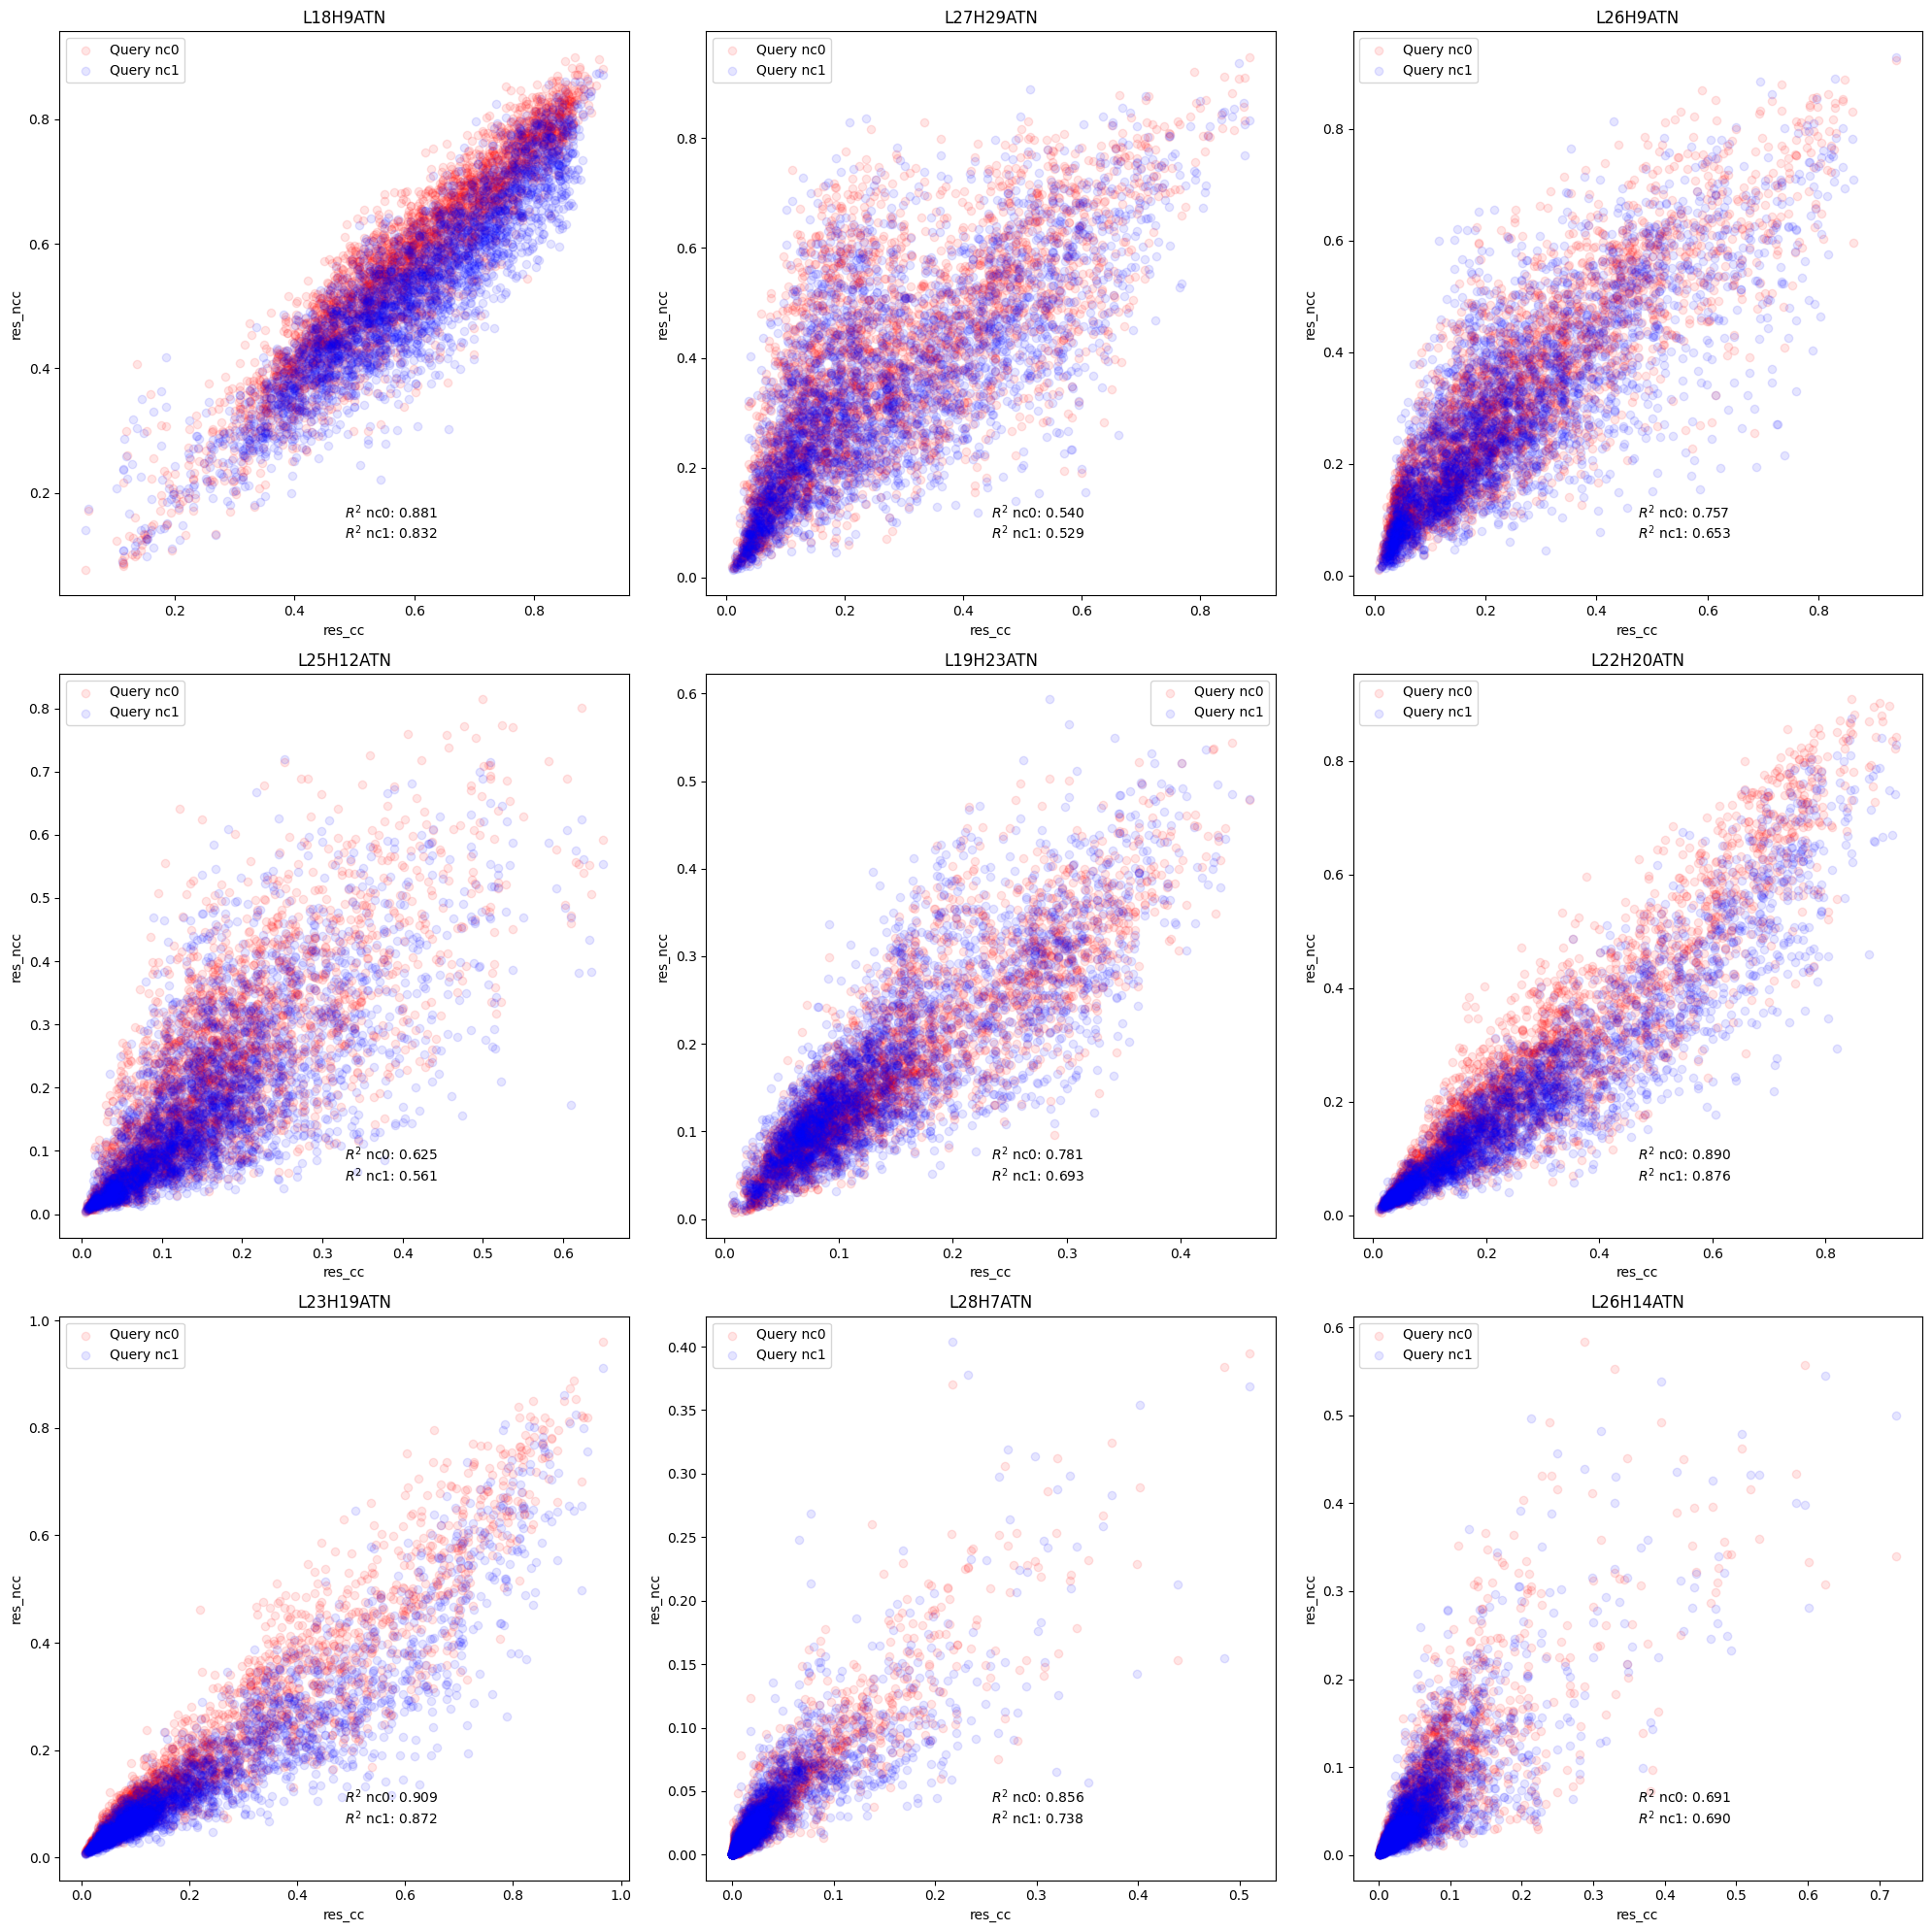

In [194]:
# res_cc = res[:, :, 0, 0]
# res_ncc_1 = res[:, :, 1, 0]
# res_ncc_2 = res[:, :, 2, 0]


# Determine the dimensions from the shape of 'res'
prompts, heads, _, _ = res.shape

# Create a new figure
plt.figure(figsize=(20, 20))

# Loop through each head
for head, head_name in zip(range(heads), important_head_list):
    # Determine the subplot position in a 9x9 grid
    position = head + 1  # positions are 1-indexed

    # Create the subplot
    plt.subplot(3, 3, position)

    # Scatter plot of res_cc vs res_ncc_1
    plt.scatter(res_cc[:, head], res_ncc_1[:, head], alpha=0.1, color='red', label='Query nc0')

    # Scatter plot of res_cc vs res_ncc_2
    plt.scatter(res_cc[:, head], res_ncc_2[:, head], alpha=0.1, color='blue', label='Query nc1')

    # Label the axes
    plt.xlabel('res_cc')
    plt.ylabel('res_ncc')

    # Title indicating the head number
    plt.title(head_name)

    # Legend to distinguish between res_ncc_1 and res_ncc_2
    plt.legend()

    # Calculate R^2 and display it in the plot
    correlation_nc0 = (pearsonr(res_cc[:, head], res_ncc_1[:, head])[0])**2
    correlation_nc1 = (pearsonr(res_cc[:, head], res_ncc_2[:, head])[0])**2
    plt.text(0.5, 0.1, f'$R^2$ nc0: {correlation_nc0:.3f}\n$R^2$ nc1: {correlation_nc1:.3f}', transform=plt.gca().transAxes)

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()

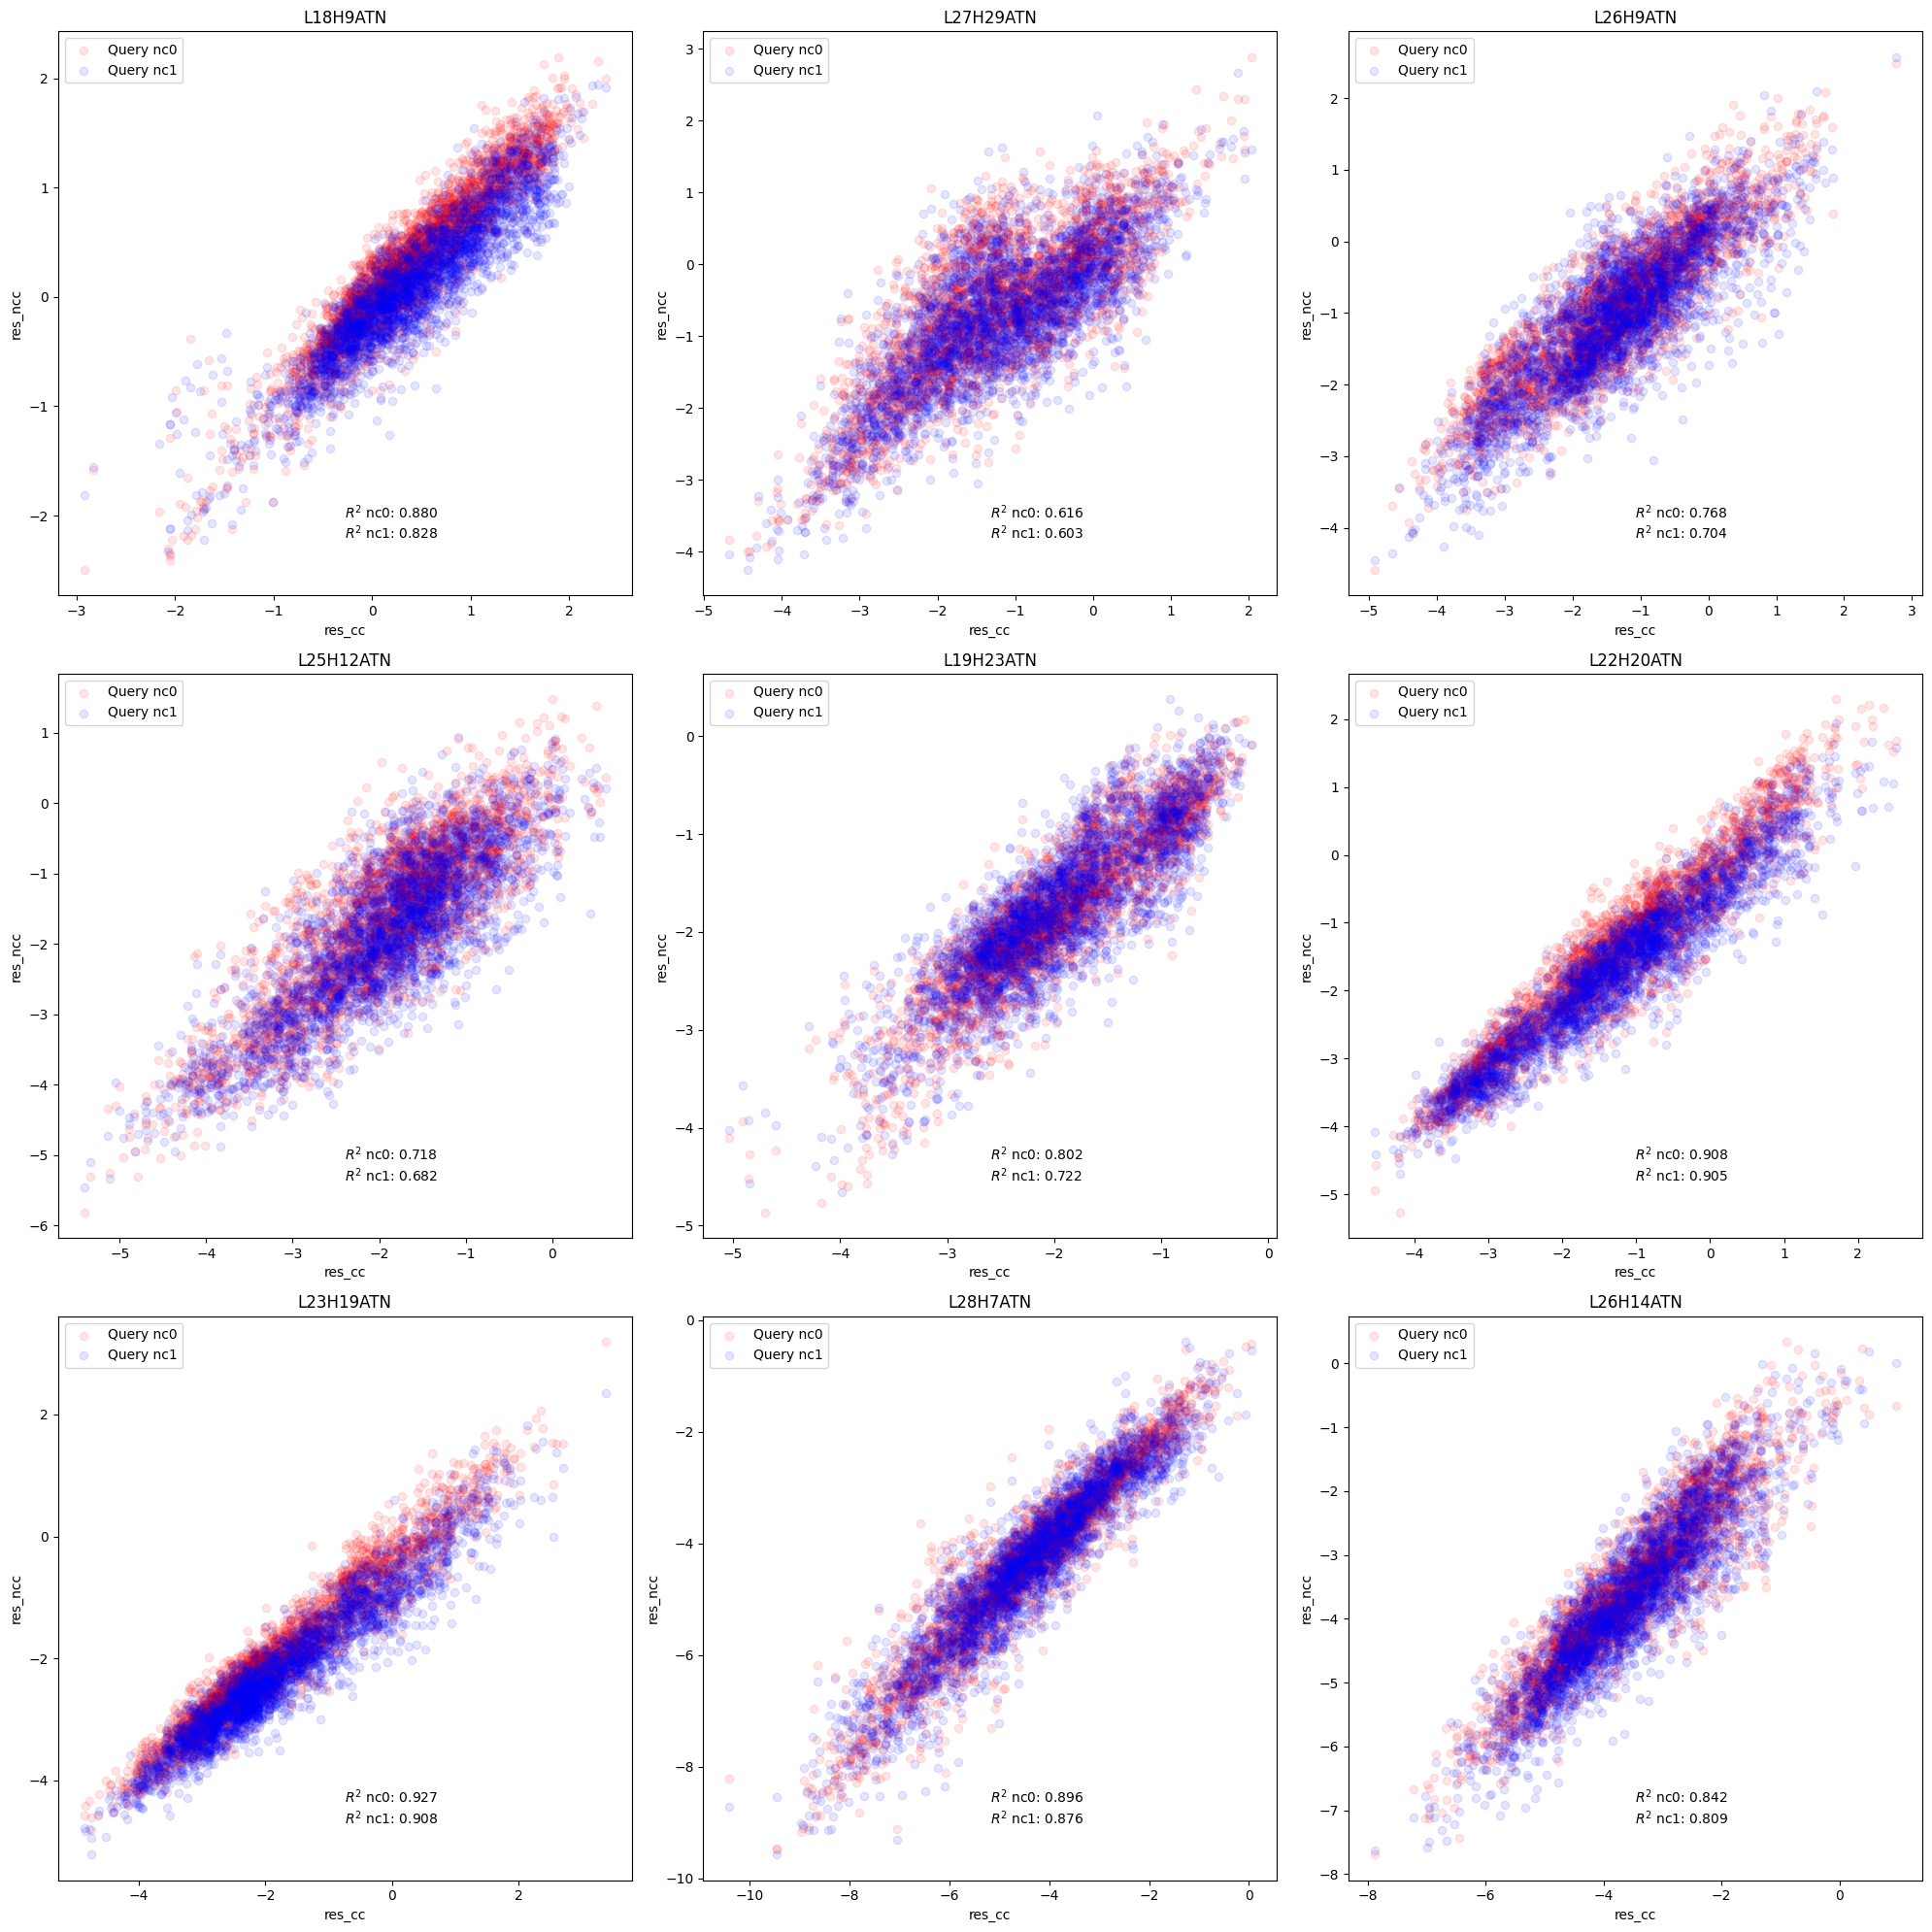

In [195]:
# Splitting the data
res_cc = torch.tensor(res[:, :, 0, 0]).logit()
res_ncc_1 = torch.tensor(res[:, :, 1, 0]).logit()
res_ncc_2 = torch.tensor(res[:, :, 2, 0]).logit()

# res_cc = res[:, :, 0, 0]
# res_ncc_1 = res[:, :, 1, 0]
# res_ncc_2 = res[:, :, 2, 0]


# Determine the dimensions from the shape of 'res'
prompts, heads, _, _ = res.shape

# Create a new figure
plt.figure(figsize=(20, 20))

# Loop through each head
for head, head_name in zip(range(heads), important_head_list):
    # Determine the subplot position in a 9x9 grid
    position = head + 1  # positions are 1-indexed

    # Create the subplot
    plt.subplot(3, 3, position)

    # Scatter plot of res_cc vs res_ncc_1
    plt.scatter(res_cc[:, head], res_ncc_1[:, head], alpha=0.1, color='red', label='Query nc0')

    # Scatter plot of res_cc vs res_ncc_2
    plt.scatter(res_cc[:, head], res_ncc_2[:, head], alpha=0.1, color='blue', label='Query nc1')

    # Label the axes
    plt.xlabel('res_cc')
    plt.ylabel('res_ncc')

    # Title indicating the head number
    plt.title(head_name)

    # Legend to distinguish between res_ncc_1 and res_ncc_2
    plt.legend()

    # Calculate R^2 and display it in the plot
    correlation_nc0 = (pearsonr(res_cc[:, head], res_ncc_1[:, head])[0])**2
    correlation_nc1 = (pearsonr(res_cc[:, head], res_ncc_2[:, head])[0])**2
    plt.text(0.5, 0.1, f'$R^2$ nc0: {correlation_nc0:.3f}\n$R^2$ nc1: {correlation_nc1:.3f}', transform=plt.gca().transAxes)

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()

In [247]:
num_prompts = len(df) // 10
# num_prompts = 10
important_heads = len(important_head_list)

n_rolls = 32
res_2 = np.zeros((num_prompts, important_heads, n_rolls))

for idx in tqdm(range(num_prompts)):
    prompt, forbidden = df.prompt_c[idx], df.target_true_str[idx]
    # run the tl model with the prompt
    with torch.no_grad():
        _, cache = tl_model.run_with_cache(prompt)

    prompt_len = tl_model.to_tokens(prompt)[0].shape[0]

    for head_id, head in enumerate(important_head_list):
        # get numbers after L, and numbers after H for layer and head
        layer, head = extract_layer_head(head)
        attn_scale = tl_model.blocks[layer].attn.attn_scale

        # Get n_rolls random ints from 0 to prompt_len - 1
        # without replacement
        rolls = np.sort(
            np.random.choice(prompt_len, size=n_rolls, replace=False)
        )
        rolls[0] = 0

        ks = cache["k", layer][0, :, head, :].float()
        rolled_ks = torch.zeros(
            (n_rolls, prompt_len, ks.shape[-1]),
            dtype=ks.dtype,
            device=ks.device,
        )
        for i in range(n_rolls):
            rolled_ks[i, :, :] = ks.roll(rolls[i], dims=0)

        rot_rolled_ks = einops.rearrange(
            tl_model.blocks[layer].attn.apply_rotary(
                einops.rearrange(rolled_ks, "roll seq d -> 1 seq roll d")
            ),
            "1 seq roll d -> roll seq d",
        )
        rot_q = cache["rot_q", layer][0, -1, head, :].float()

        rolled_scores = rot_rolled_ks @ rot_q / attn_scale
        rolled_attn = rolled_scores.softmax(dim=-1)

        unrolled_attn = torch.zeros(
            (n_rolls, prompt_len), dtype=ks.dtype, device=ks.device
        )
        for i in range(n_rolls):
            unrolled_attn[i, :] = rolled_attn[i, :].roll(-rolls[i], dims=0)

        forbidden_attn_slice = get_forbidden_token_range(prompt, forbidden)
        res_2[idx, head_id, :] = (
            unrolled_attn[:, forbidden_attn_slice].sum(dim=-1).cpu().numpy()
        )

  0%|          | 0/307 [00:00<?, ?it/s]

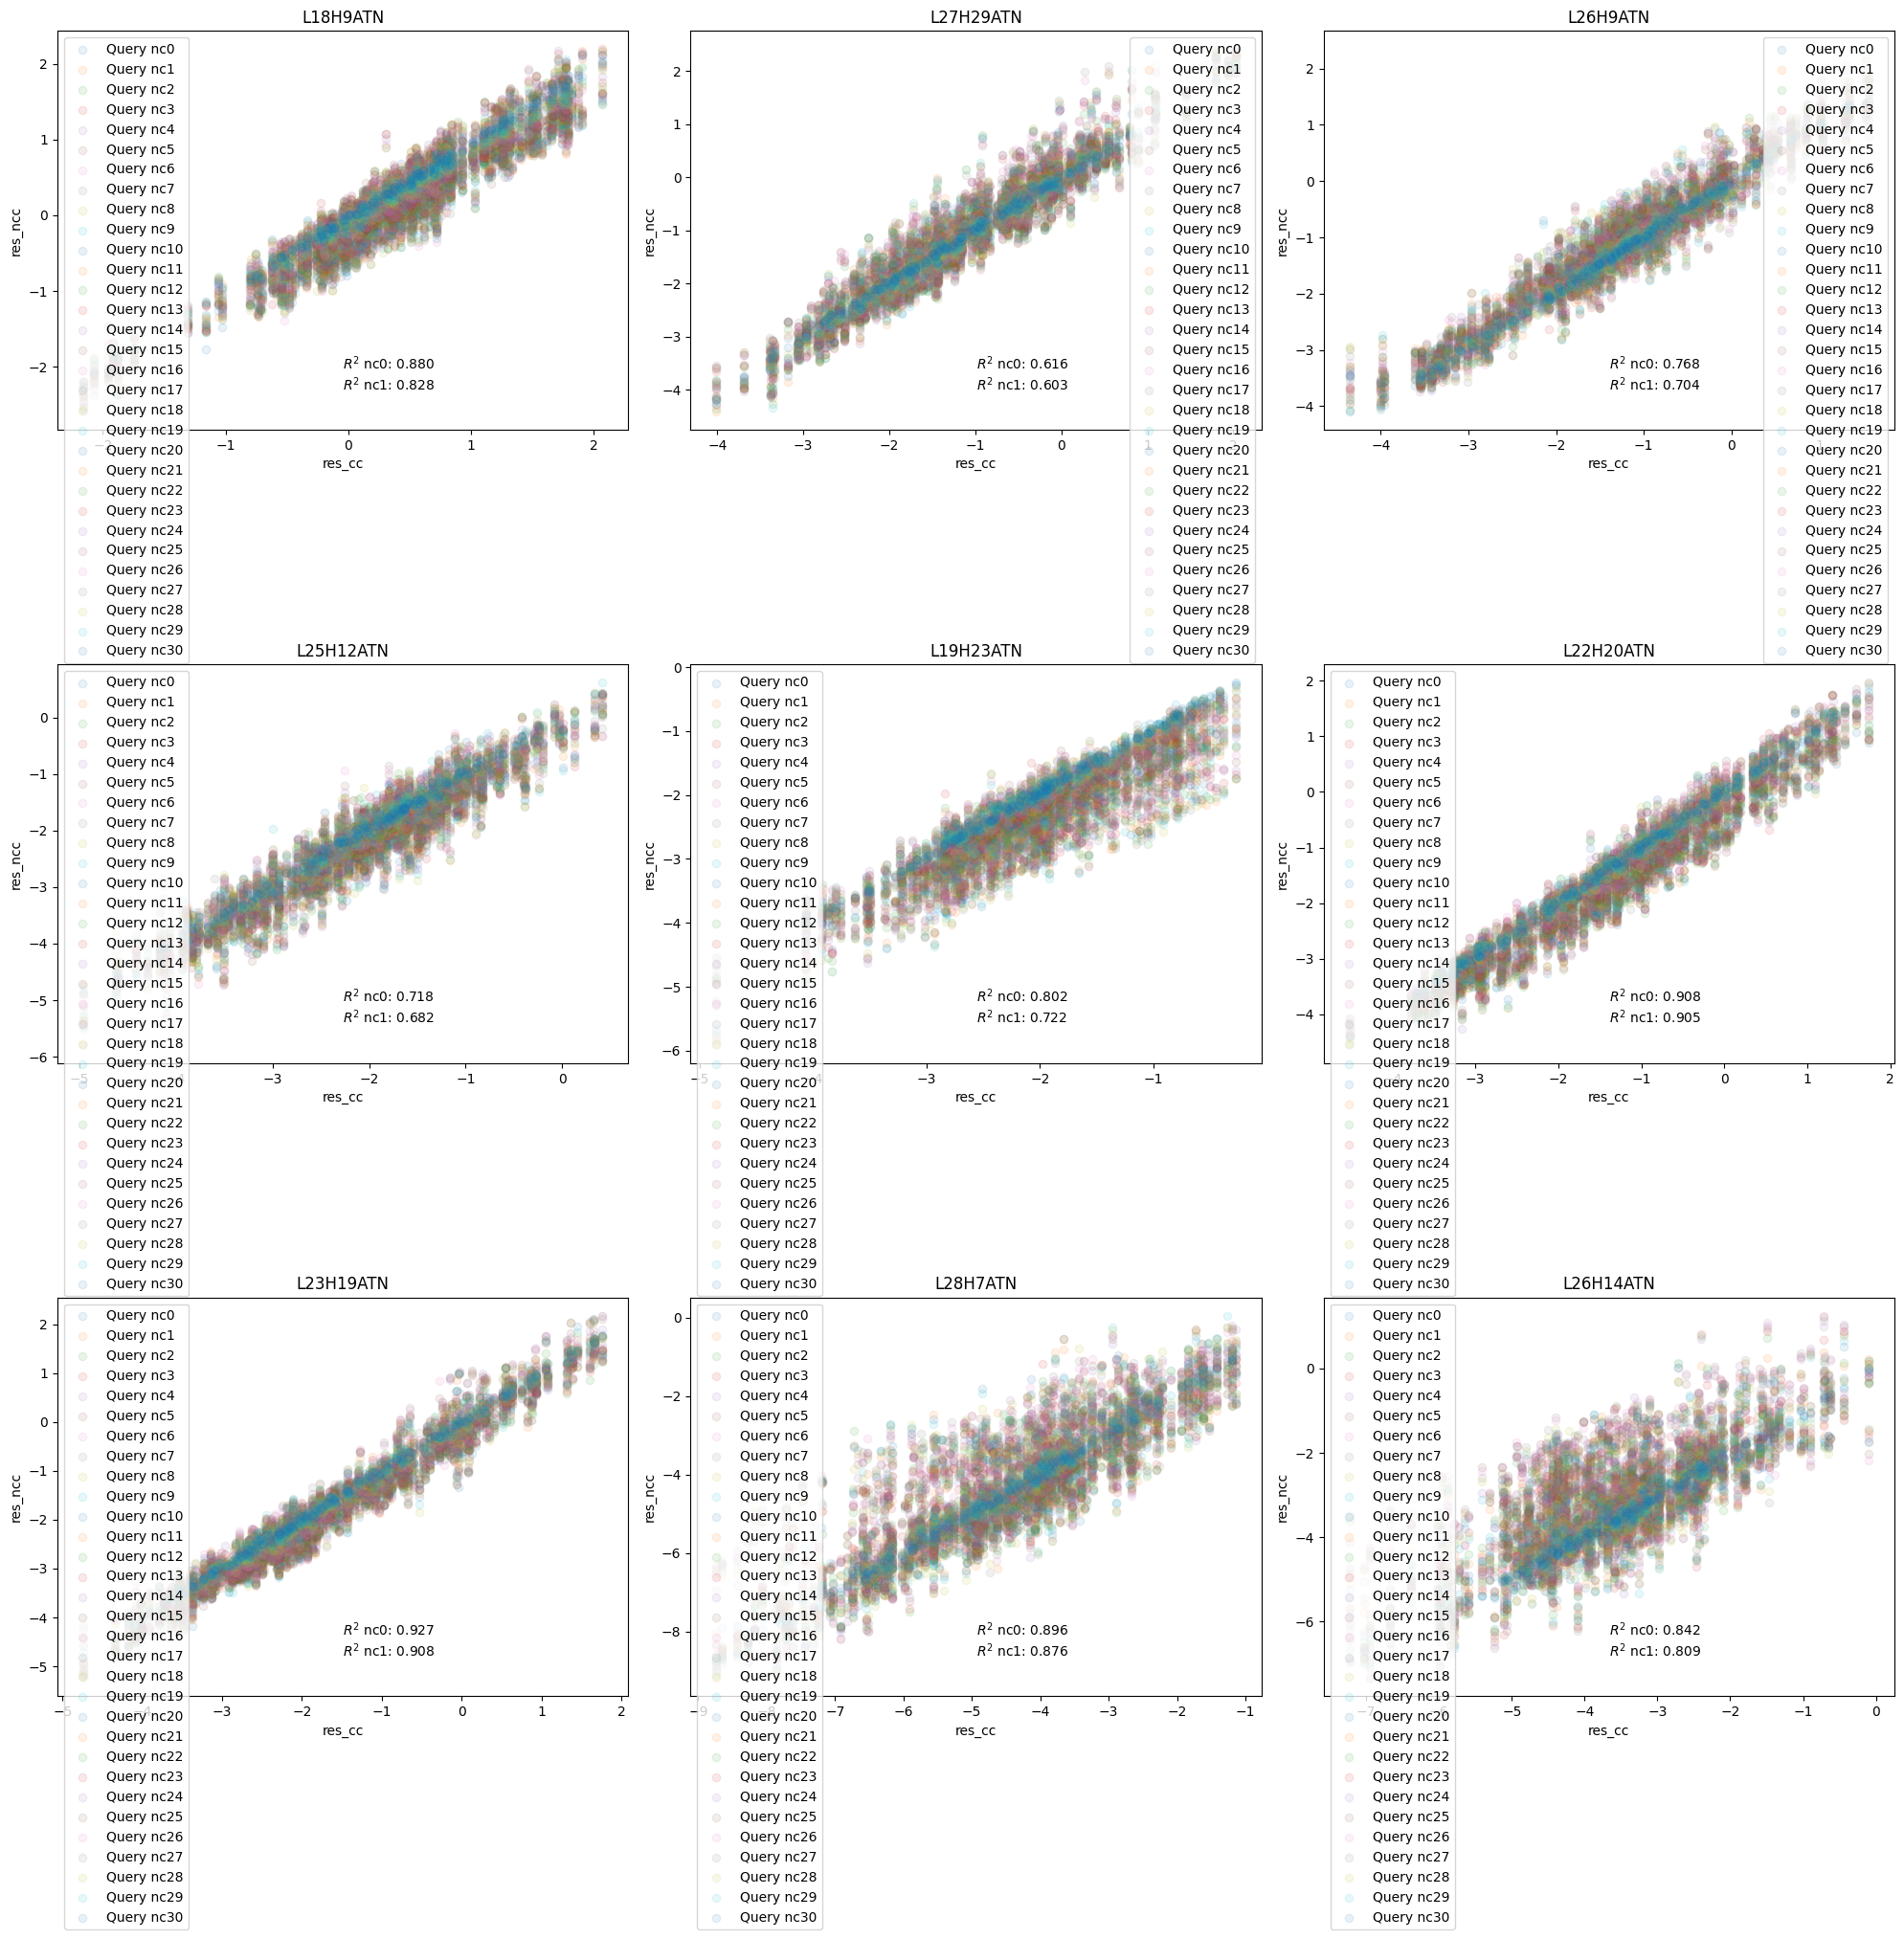

In [249]:
# Splitting the data
res2_orig = torch.tensor(res_2[:, :, 0]).logit()
#concat all other rolls
res2_perm = torch.tensor(res_2[:, :, 1:]).logit()


# Determine the dimensions from the shape of 'res'
prompts, heads, _, _ = res.shape

# Create a new figure
plt.figure(figsize=(20, 20))

# Loop through each head
for head, head_name in zip(range(heads), important_head_list):
    # Determine the subplot position in a 9x9 grid
    position = head + 1  # positions are 1-indexed

    # Create the subplot
    plt.subplot(3, 3, position)

    # Scatter plot of res_orig vs res_perm
    for extra_dim_index in range(res_2.shape[-1] - 1):
        plt.scatter(res2_orig[:, head], res2_perm[:, head, extra_dim_index], alpha=0.1, label=f'Query nc{extra_dim_index}')
    # Label the axes
    plt.xlabel('res_cc')
    plt.ylabel('res_ncc')

    # Title indicating the head number
    plt.title(head_name)

    # Legend to distinguish between res_ncc_1 and res_ncc_2
    plt.legend()

    # Calculate R^2 and display it in the plot
    correlation_nc0 = (pearsonr(res_cc[:, head], res_ncc_1[:, head])[0])**2
    correlation_nc1 = (pearsonr(res_cc[:, head], res_ncc_2[:, head])[0])**2
    plt.text(0.5, 0.1, f'$R^2$ nc0: {correlation_nc0:.3f}\n$R^2$ nc1: {correlation_nc1:.3f}', transform=plt.gca().transAxes)

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()